## Recomendacion Jugadores

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import keras
import seaborn.objects as so



pd.options.display.max_columns = None
pd.set_option('display.max_columns', None)

Leemos los datos del csv con pandas y lo guardamos en una variable "data"

In [50]:
data = pd.read_csv ("transfermarkt_fbref_201920.csv", delimiter =';')
data = data[data['minutes'] > 500]
display(data)


,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,foot,league,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,games_starts_gk,minutes_gk,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_allowed,pens_saved,pens_missed_gk,minutes_90s_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_

Aclaraciones sobre el dataFrame: 

SCA (Shot-Creating Action: Acción de creación de disparo). Son las dos acciones ofensivas previas a un disparo. Un único jugador puede acumular más de una acción en una misma jugada, por ejemplo, si realiza con éxito un regate y da el pase al jugador que ejecuta el disparo. Las acciones que se tienen en cuenta son las siguientes:

GCA (Goal-Creating Action: Acción de creación de gol). Son las dos acciones ofensivas previas a un gol. En lo demás, es completamente análogo al SCA, pero en esta ocasión el disparo acaba entrando en la portería.

#### (a)
En 2021 Messi fue transferido del Barcelona al PSG. Basandose en los datos disponibles, buscamos recomendarle a Barcelona un jugador de caracterısticas similares a Messi pero de menor valor.

In [51]:
Delanteros = data[data['position'].str.contains('FW')].reset_index(drop=True)
def unicos(dataFrame):
  for columna, num_unicos in dataFrame.nunique().items():
    print(f'{columna}: {num_unicos}')

Quito del df de delanteros los datos que tienen un solo unique, que representan estadististicas en las que todos los jugadores tienen el mismo valor

In [52]:
Delanteros = Delanteros[Delanteros.columns[Delanteros.nunique() > 1]]

Veamos en que estadisticas destaca Messi, ya que tenemos en cuenta que los jugadores parecidos a el destacaran en las mismas (No tiene sentido comparar, por ejemplo, cantidad de quites de Messi)

In [74]:
#Quiero ver donde destaca messi
Messi = "Lionel Messi"
DatosMessi = Delanteros.loc[Delanteros['player'] == Messi]
Delanteros_num = Delanteros.select_dtypes(include='number')
promedio = Delanteros_num.mean()
DatosMessi_num = DatosMessi.select_dtypes(include='number').squeeze()

Promedio_Messi = DatosMessi_num/promedio
Messi_destacado = pd.concat([Promedio_Messi[Promedio_Messi > 2], Promedio_Messi[Promedio_Messi < 0.3]], axis=0)

Sabiendo donde destaca Messi, vamos a escalar los datos con Scaler MinMax, para que un dato no pese mas que otro (nos quedan todos los datos entre 0 y 1) y vamos a calcular el jugador mas cercano a Messi teniendo en cuenta que sabemos donde es diferencial

In [75]:
scaler = MinMaxScaler().set_output(transform="pandas")
Delanteros_num_scaled = scaler.fit_transform(Delanteros_num)
Delanteros_num_scaled
#Eliminamos columnas que no nos interesan
Delanteros_num_scaled = Delanteros_num_scaled.drop(columns=["Column1",
                                                            "age",
                                                            "birth_year",
                                                            "value",
                                                            "height",
                                                            "games",
                                                            "games_starts",
                                                            "minutes",
                                                            "cards_yellow",
                                                            "cards_red",
                                                            "CL",
                                                            "WinCL",
                                                            "CLBestScorer"])
#Agregamos identificadores (Nombre) y valor de mercado
Nombres = Delanteros['player']
Precio_Mercado = Delanteros['value']
Delanteros_Scaled = pd.concat([Nombres, Delanteros_num_scaled], axis=1)
#Veamos como queda el DataFrame
display(Delanteros_Scaled)

,player,goals,assists,pens_made,pens_att,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_offsidesm,passes_oobm,passes_interceptedm,passes_blockedm,scam,sca_per90m,sca_passes_livem,sca_passes_deadm,sca_dribblesm,sca_shotsm,sca_fouledm,gcam,gca_per90m,gca_passes_livem,gca_passes_deadm,gca_dribblesm,gca_shotsm,gca_fouledm,gca_og_form,tacklesm,tackles_wonm,tackles_def_3rdm,tackles_mid_3rdm,tackles_att_3rdm,dribble_tacklesm,dribbles_vsm,dribble_tackles_pctm,dribbled_pastm,pressuresm,pressure_regainsm,pressure_regain_pctm,pressures_def_3rdm,pressures_mid_3rdm,pressures_att_3rdm,blocksm,blocked_shotsm,blocked_shots_savesm,blocked_passesm,interceptionsm,clearancesm,errorsm,touchesm,touches_def_pen_aream,touches_def_3rdm,touches_mid_3rdm,touches_att_3rdm,touches_att_pen_aream,touches_live_ballm,dribbles_completedm,dribblesm,dribbles_completed_pctm,players_dribbled_pastm,nutmegsm,carriesm,carry_distancem,carry_progressive_distancem,pass_targetsm,passes_rec

Calculamos la distancia de Messi a todos los delanteros

In [55]:
Columnas = ['player'] + list(Messi_destacado.drop(['value', 'CL', 'cards_red', 'WinCL', 'CLBestScorer']).index)
Delanteros_scales_Messi = Delanteros_Scaled[Columnas]
Messi_Datos = Delanteros_scales_Messi.loc[Delanteros_scales_Messi['player'] == Messi].drop(columns=['player'])
Distancia_a_Messi = round(np.sqrt(((Delanteros_scales_Messi.drop(columns=['player']) - Messi_Datos.squeeze())**2).sum(axis=1)), 2)
Distancia_por_jugador = pd.concat([Nombres, Distancia_a_Messi, Precio_Mercado], axis=1).rename(columns={0:"Distancia"})
Distancia_por_jugador

,player,Distancia,value
0,Oliver Burke,8.29,4000000
1,Joselu,7.21,5000000
2,Édgar Méndez,8.61,1600000
3,Lucas Pérez,6.65,12000000
4,Borja Sainz,8.53,30000
...,...,...,...
603,Wout Weghorst,6.97,21000000
604,Raúl Jiménez,6.19,40000000
605,Diogo Jota,6.39,40000000
606,Pedro Neto,6.98,11000000


Ahora veamos el top 10 de jugadores "mas parecidos" a Messi, que tengan un valor menor a 112000000 (112M)

In [56]:
Jugadores_a_recomendar = Distancia_por_jugador[Distancia_por_jugador['value'] < 112000000].sort_values(by='Distancia').head(11)
display(Jugadores_a_recomendar)

,player,Distancia,value
30,Papu Gómez,4.07,15000000
422,Ángel Di Marí­a,4.08,32000000
242,Paulo Dybala,4.16,72000000
323,Riyad Mahrez,4.52,48000000
31,Josip Ilicic,4.69,15000000
381,Lorenzo Insigne,5.04,48000000
352,Hakan í‡alhanoÄźlu,5.06,30000000
132,Willian,5.11,19000000
490,Domenico Berardi,5.14,19000000
32,Ruslan Malinovskyi,5.18,11000000


Podemos ver que, curiosamente, los primeros 3 jugadores que aparecen son delanteros argentinos, esto puede ser porque los jugadores argentinos de caracter habilidoso tienen una forma diferencial de jugar, pero esto no quita que sea un dato como minimo sorpresivo

In [57]:
#Creo una funcion que generalice lo hecho anteriormente

def top10JugadoresParecidos(player, data=data):
#esta funcion presupone que los jugadores no aparecen repetidos (Si de equipo en invierno, no)
  Datos_Jugador = data[data['player'] == player]
  Posicion =  Datos_Jugador['position'].values[0][0:2]
  Jugadores_Posicion = data[data['position'].str.contains(Posicion)].reset_index(drop=True)
  Promedio = Jugadores_Posicion.select_dtypes(include='number').mean()
  Promedio_del_jugador = Datos_Jugador.select_dtypes(include='number').squeeze()/Promedio
  Columnas_destacadas = pd.concat([Promedio_del_jugador[Promedio_del_jugador > 2], Promedio_del_jugador[Promedio_del_jugador > 0.3]], axis=0)

  scaler = MinMaxScaler().set_output(transform="pandas")
  Jugadores_Posicion_num_scaled = scaler.fit_transform(Jugadores_Posicion.select_dtypes(include='number'))
  #Quito columnas que prefiero no esten porque nublan los datos reales
  Jugadores_Posicion_num_scaled.drop(columns=["Column1",
                                              "age",
                                              "birth_year",
                                              "value",
                                              "height",
                                              "games",
                                              "games_starts",
                                              "minutes"])
  Nombres = Jugadores_Posicion['player']
  Precio_Mercado = Jugadores_Posicion['value']
  Jugadores_num_con_Nombre = pd.concat([Nombres, Jugadores_Posicion_num_scaled], axis=1)
  Columnas = ['player'] + list(Columnas_destacadas.index)
  Jugadores_scaled = Jugadores_num_con_Nombre[Columnas]
  Player_datos = Jugadores_scaled.loc[Jugadores_scaled['player'] == player].drop(columns=['player'])
  Distancias = round(np.sqrt(((Jugadores_scaled.drop(columns=['player']) - Player_datos.squeeze())**2).sum(axis=1)), 2)
  Distancias_por_jugador = pd.concat([Nombres, Distancias, Precio_Mercado], axis=1).rename(columns={0:"Distancia"})

  return Distancias_por_jugador



#### (b)
Queremos elaborar un modelo para detectar jugadores “baratos”, es decir cuya valuacion en el mercado (columna value) sea inferior a la que nosotros estimemos. Para esto, quisieramos ajustar el valor de mercado a partir de los datos de los jugadores.

In [58]:
#quito los jugadores duplicados, ya que pueden generar problemas
Datos_limpios = data.drop_duplicates(subset=['player'], keep='first').reset_index(drop=True)
Datos_limpios = Datos_limpios.drop(columns = ['Column1'])
Datos_limpios.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,league,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,games_starts_gk,minutes_gk,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_allowed,pens_saved,pens_missed_gk,minutes_90s_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_offsides

Limpio los datos, quitando datos irrelevantes como la fecha de nacimiento, o colectivos, como partidos ganados.

In [59]:
Datos_limpios_num = Datos_limpios.select_dtypes(include='number')
Col = ['birth_year', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GDiff', 'CL', 'WinCL', 'CLBestScorer']
Datos_limpios_num = Datos_limpios_num.drop(columns=Col).dropna()
Datos_limpios_num

,age,value,height,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_gk,games_starts_gk,minutes_gk,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,draws_gk,losses_gk,clean_sheets,clean_sheets_pct,pens_att_gk,pens_allowed,pens_saved,pens_missed_gk,minutes_90s_gk,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goalsm,assistsm,pens_madem,pens_attm,cards_yellowm,cards_redm,goals_per90m,assists_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,xgm,npxgm,xam,xg_per90m,xa_per90m,xg_xa_per90m,npxg_per90m,npxg_xa_per90m,minutes_90sm,shots_totalm,shots_on_targetm,shots_free_kicksm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,goals_per_shotm,goals_per_shot_on_targetm,npxg_per_shotm,xg_netm,npxg_netm,passes_completedm,passesm,passes_pctm,passes_total_distancem,passes_progressive_distancem,passes_completed_shortm,passes_shortm,passes_pct_shortm,passes_completed_mediumm,passes_mediumm,passes_pct_mediumm,passes_completed_longm,passes_longm,passes_pct_longm,xa_netm,assisted_shotsm,passes_into_final_thirdm,passes_into_penalty_aream,crosses_into_penalty_aream,progressive_passesm,passes_livem,passes_deadm,passes_free_kicksm,through_ballsm,passes_pressurem,passes_switchesm,crossesm,corner_kicksm,corner_kicks_inm,corner_kicks_outm,corner_kicks_straightm,passes_groundm,passes_lowm,passes_highm,passes_left_footm,passes_right_footm,passes_headm,throw_insm,passes_other_bodym,passes_offsidesm,passes_oobm,passes_interceptedm,passes_blockedm,scam,sca_per90m,s

Declaro la variable(s) independiente(s) y la que quier predecir

In [60]:
X = Datos_limpios_num.drop(columns=['value'])
y = Datos_limpios_num['value']


Vamos a predecir el precio de los jugadores con redes neuronales

In [62]:
#Redes neuronales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#escalo los datos
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)

scalerY = StandardScaler()
y_train_scaled = scalerY.fit_transform(pd.DataFrame(y_train))
y_test_scaled = scalerY.transform(pd.DataFrame(y_test))



keras.utils.set_random_seed(11)

# Paso 1: iniciamos el modelo indicando la arquitectura de la red
shape = X_train_scaled.shape[1]
model = keras.Sequential([
    keras.layers.Input((shape, )),                                          
    keras.layers.Dense(150),
    keras.layers.Dense(100),
    keras.layers.Dense(50),
    keras.layers.Dense(1, activation='relu')
])

lr = 0.001

# Paso 2: configuramos el optimizador:
optimizer = keras.optimizers.SGD(learning_rate=lr)

# Paso 3: construimos el modelo
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error']
)

# Paso 4: entrenamiento del modelo.
epocas = 30
batch_size = 20
split = 0.2
hist = model.fit(X_train_scaled, y_train_scaled,    # Ingresamos los datos de entrenamiento
                    epochs=epocas,                                     # Especificamos la cantidad de épocas
                    batch_size=batch_size,                             # Especificamos el tamaño del batch
                    validation_split=split,                            # 20% de datos para validación
                    verbose=1,                                         # Opcional, para que no muestre el proceso de entrenamiento.
                    )

# Paso 5: calculamos el error en el conjunto de testeo
model.evaluate(X_test_scaled, y_test_scaled,
                verbose=0,
                batch_size=len(y_test),
                return_dict=True
                )



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1894 - mean_absolute_error: 0.8213 - mean_squared_error: 1.1894 - val_loss: 0.6493 - val_mean_absolute_error: 0.6352 - val_mean_squared_error: 0.6493
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5978 - mean_absolute_error: 0.5980 - mean_squared_error: 0.5978 - val_loss: 0.6009 - val_mean_absolute_error: 0.6127 - val_mean_squared_error: 0.6009
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5515 - mean_absolute_error: 0.5767 - mean_squared_error: 0.5515 - val_loss: 0.5778 - val_mean_absolute_error: 0.6002 - val_mean_squared_error: 0.5778
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5295 - mean_absolute_error: 0.5694 - mean_squared_error: 0.5295 - val_loss: 0.5566 - val_mean_absolute_error: 0.5904 - val_mean_squared_error: 0.5566
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5056 - mean_absolute_error: 0.5613 - mean_squared_error: 0.5056 - val_loss: 0.5310 - val_mean_absolu

[None, None, None]

Analicemos como avanza el error a travez de las epocas

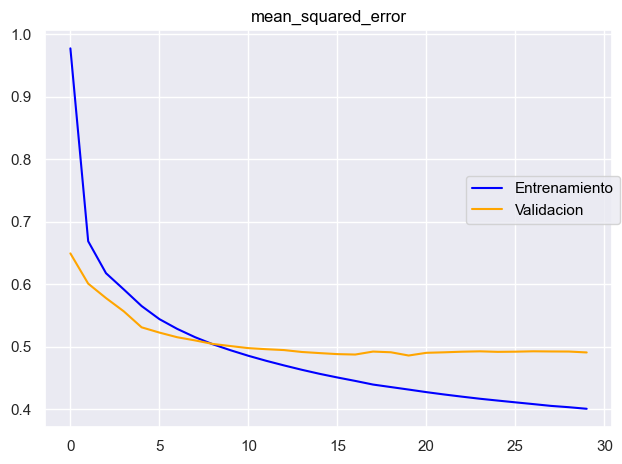

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([0.], dtype=float32)

In [63]:

x_arr = np.array(hist.epoch)    # en el atributo epoch, history guarda una lista de epocas
plot = (
    so.Plot()
    .add(so.Line(color='blue'), x=x_arr, y=hist.history['mean_squared_error'], label='Entrenamiento')
    .add(so.Line(color='orange'), x=x_arr, y=hist.history[f'val_mean_squared_error'], label='Validacion')
    .label(title='mean_squared_error')
    # .limit(y=(10**14.5, 10**14.7)) #Hay valores cercanos a "infinito" (Nan), por eso pongo limite de y's
)
plot.show()

Valores_predichos = model.predict(scalerX.transform(X))
pd.Series(Valores_predichos[1]).unique()

Como vemos que el erro de validacion se estanca, consideramos que la cantidad de epocas es la optima y no debe ser aumentada, de forma que predecimos los precios para todos nuestros jugadores

In [64]:
round3 = lambda numero : np.round(numero, 3 - int(np.floor(np.log10(abs(numero)))) - 1)
Valores_predichos = pd.Series(scalerY.inverse_transform(model.predict(scalerX.transform(X)))[:, 0]) #.apply(scalerY.inverse_transform)
Valores_predichos = Valores_predichos.apply(round3)
print(Valores_predichos.nunique()) 
Tabla_De_valores = pd.concat([Datos_limpios[['player', 'value']], Valores_predichos], axis=1).rename(columns={0:"Valor_predicho"})

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304


#### (c) Segun el modelo desarrollado, entre los jugadores con un valor de mercado mayor a $100000, ¿quien es el mas sobrevalorado? Es decir, el jugador con mayor diferencia entre el valor de mercado y el valor predicho por el modelo. ¿Y el mas infravalorado?


Para responder a esta pregunta vamos a tomar 2 metricas
1. La diferencia entre el valor real y el valor predicho, si esta diferencia es negativa, el jugador esta infravalorado y si es posita esta sobrevalorado
2. Un indice de variacion de precio con la formula valor real / valor predicho, si este indice es menor a 1 el jugador esta infravalorado, si es mayor esta sobrevalorado

In [65]:
Tabla_De_valores["Diferencia"] = Tabla_De_valores['value'] - Tabla_De_valores["Valor_predicho"]
Tabla_De_valores["Indice_Var"]  = Tabla_De_valores['value'] / Tabla_De_valores["Valor_predicho"]
Tabla_De_valores[Tabla_De_valores['value'] > 100000]

,player,value,Valor_predicho,Diferencia,Indice_Var
0,Martin Aguirregabiria,4000000,12200000.0,-8200000.0,0.327869
1,Oliver Burke,4000000,12200000.0,-8200000.0,0.327869
2,Ví­ctor Camarasa,4000000,12200000.0,-8200000.0,0.327869
3,Rubén Duarte,4000000,12200000.0,-8200000.0,0.327869
4,Rodrigo Ely,1000000,12200000.0,-11200000.0,0.081967
...,...,...,...,...,...
1886,Pedro Neto,11000000,16900000.0,-5900000.0,0.650888
1887,Rúben Neves,40000000,38400000.0,1600000.0,1.041667
1888,Rui Patrí­cio,16000000,16900000.0,-900000.0,0.946746
1889,Romain Saïss,4000000,12200000.0,-8200000.0,0.327869


In [78]:
#Top 3 sobrevalorados
print("Top 3 sobrevalorados \n")
print("Por diferencia de valores:")
Jugadores = list(Tabla_De_valores[Tabla_De_valores['value'] > 100000].sort_values(by="Diferencia", ascending=False).iloc[:3][['player', 'value', 'Valor_predicho']].values)
[print(i+1, player[0], "\n", 'valor real :', player[1],"\t", 'valor predicho :',int(player[2])) for i, player in enumerate(Jugadores)]

print("\nPor indice de variacion:")
Jugadores = list(Tabla_De_valores[Tabla_De_valores['value'] > 100000].sort_values(by="Indice_Var", ascending=False).iloc[:3][['player', 'value', 'Valor_predicho']].values)
[print(i+1, player[0], "\n", 'valor real :', player[1],"\t", 'valor predicho :',int(player[2])) for i, player in enumerate(Jugadores)]
print()

Top 3 sobrevalorados 

Por diferencia de valores:
1 Harry Kane 
 valor real : 120000000 	 valor predicho : 31900000
2 Kevin De Bruyne 
 valor real : 120000000 	 valor predicho : 57400000
3 N'Golo Kanté 
 valor real : 80000000 	 valor predicho : 19700000

Por indice de variacion:
1 N'Golo Kanté 
 valor real : 80000000 	 valor predicho : 19700000
2 Gianluigi Donnarumma 
 valor real : 49000000 	 valor predicho : 12200000
3 Alexandre Lacazette 
 valor real : 48000000 	 valor predicho : 12200000



In [79]:
#Top 3 infravalorados
print("Top 3 infravalorados \n")
print("Por diferencia de valores:")
Jugadores = list(Tabla_De_valores[Tabla_De_valores['value'] > 100000].sort_values(by="Diferencia").iloc[:3][['player', 'value', 'Valor_predicho']].values)
[print(i+1, player[0], "\n", 'valor real :', player[1],"\t", 'valor predicho :',player[2]) for i, player in enumerate(Jugadores)]

print("\nPor indice de variacion:")
Jugadores = list(Tabla_De_valores[Tabla_De_valores['value'] > 100000].sort_values(by="Indice_Var").iloc[:3][['player', 'value', 'Valor_predicho']].values)
[print(i+1, player[0], "\n", 'valor real :', player[1],"\t", 'valor predicho :',player[2]) for i, player in enumerate(Jugadores)]
print()

Top 3 infravalorados 

Por diferencia de valores:
1 Josip Ilicic 
 valor real : 15000000 	 valor predicho : 64000000.0
2 Edinson Cavani 
 valor real : 20000000 	 valor predicho : 65300000.0
3 Karim Benzema 
 valor real : 32000000 	 valor predicho : 75600000.0

Por indice de variacion:
1 Ví­ctor Dí­az 
 valor real : 1000000 	 valor predicho : 12200000.0
2 Steven Skrzybski 
 valor real : 1000000 	 valor predicho : 12200000.0
3 Raphael Framberger 
 valor real : 1000000 	 valor predicho : 12200000.0



#### (d) El PSG quiere vender a Mbappe y reemplazarlo por otro jugador mas barato. Hacer un listado de los 10 jugadores mas parecidos a Mbappe segun el criterio que elijan. De esos 10 jugadores, segun el modelo que desarrollaron en el item anterior, ¿a que jugador recomendarıan teniendo en cuenta la valuacion del mercado y la prediccion del modelo? Para ese jugador, averiguar la valuacion actual del jugador. ¿Hicieron una buena recomendacion?

In [68]:
#Listado de 10 jugadores mas parecidos a Mbappe:
Top10_mbappe = top10JugadoresParecidos("Kylian Mbappé").sort_values(by='Distancia').head(11)
display(Top10_mbappe)

,player,Distancia,value
424,Kylian Mbappé,0.00,180000000
33,Luis Muriel,3.60,15000000
63,Serge Gnabry,3.77,72000000
442,Timo Werner,3.79,64000000
64,Robert Lewandowski,3.94,56000000
320,Sergio AgíĽero,4.06,52000000
322,Gabriel Jesus,4.08,56000000
60,Luis Suárez,4.11,28000000
425,Neymar,4.12,128000000
35,Duván Zapata,4.13,36000000


In [69]:
Top10_mbappe = Top10_mbappe.merge(Tabla_De_valores)
display(Top10_mbappe)

,player,Distancia,value,Valor_predicho,Diferencia,Indice_Var
0,Kylian Mbappé,0.00,180000000,135000000.0,45000000.0,1.333333
1,Luis Muriel,3.60,15000000,56400000.0,-41400000.0,0.265957
2,Serge Gnabry,3.77,72000000,82100000.0,-10100000.0,0.876979
3,Timo Werner,3.79,64000000,93100000.0,-29100000.0,0.687433
4,Robert Lewandowski,3.94,56000000,92400000.0,-36400000.0,0.606061
5,Sergio AgíĽero,4.06,52000000,75800000.0,-23800000.0,0.686016
6,Gabriel Jesus,4.08,56000000,82600000.0,-26600000.0,0.677966
7,Luis Suárez,4.11,28000000,58300000.0,-30300000.0,0.480274
8,Neymar,4.12,128000000,107000000.0,21000000.0,1.196262
9,Duván Zapata,4.13,36000000,65800000.0,-29800000.0,0.547112


Teniendo en cuenta todas las variables, el jugador optimo para remplazar a Mbappe, segun nuestro modelo, seria Luis Muriel, ya que es el jugador mas cercano a el y ademas esta en la lista de los mas infravalorados